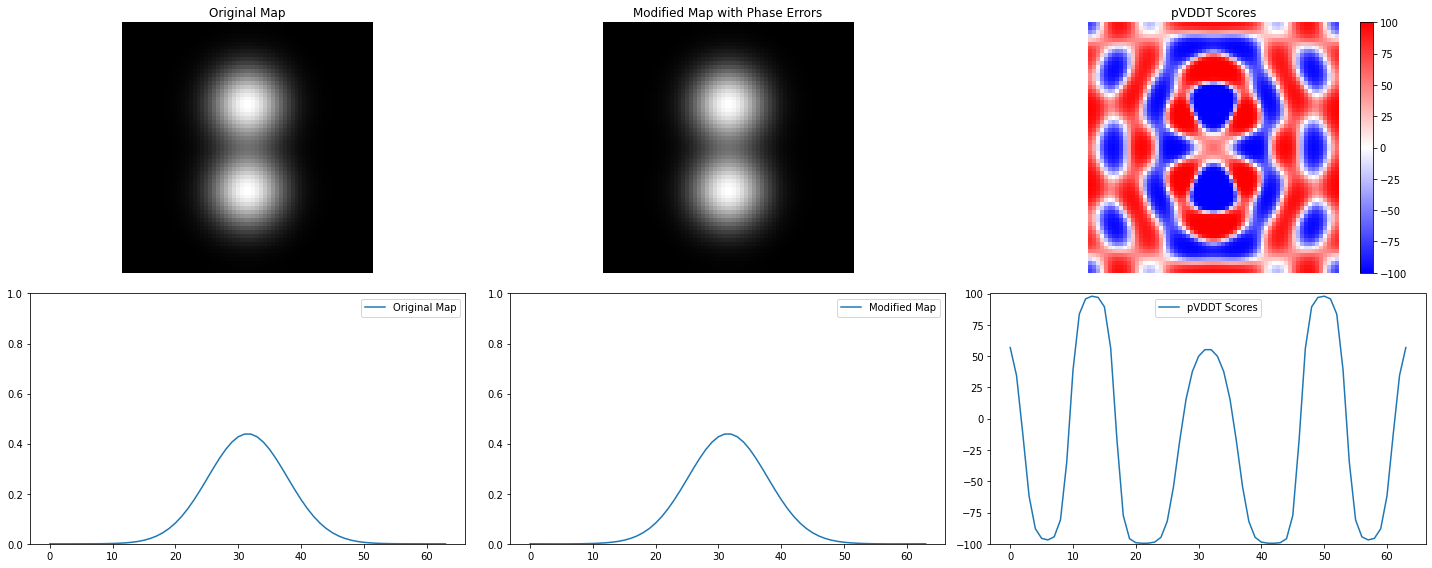

-0.00044517482140326 0.998605579397912


In [36]:
import numpy as np
import scipy.fftpack as fft
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the size of the map
N = 64  # Adjust the size as needed

# Generate a synthetic 3D density map (e.g., a Gaussian blob)
def generate_synthetic_map(N):
    x = np.linspace(-1, 1, N)
    y = np.linspace(-1, 1, N)
    z = np.linspace(-1, 1, N)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    sigma = 0.2
    rho = np.exp(-(X**2 + Y**2 + Z**2) / (2 * sigma**2))
    # roll the map to make it more interesting
    x_roll = np.random.randint(-N//4, N//4)
    y_roll = np.random.randint(-N//4, N//4)
    z_roll = np.random.randint(-N//4, N//4)
    rho = np.roll(rho, x_roll, axis=0)
    rho = np.roll(rho, y_roll, axis=1)
    #rho = np.roll(rho, z_roll, axis=2)

    rho2 = np.exp(-(X**2 + Y**2 + Z**2) / (2 * sigma**2))
    rho2 = np.roll(rho2, -1 * x_roll, axis=0)
    rho2 = np.roll(rho2, -1 * y_roll, axis=1)
    #rho2 = np.roll(rho2, -1 * z_roll, axis=2)

    rho_sum = rho + rho2
    # normalize the map
    rho_sum = rho_sum / np.max(rho_sum)
    return rho_sum

# Compute the Fourier transform of the map
def compute_structure_factor(rho):
    F = fft.fftn(rho)
    F_shifted = fft.fftshift(F)
    return F_shifted

# Introduce controlled phase errors
def introduce_phase_errors(F, max_phase_error):
    amplitudes = np.abs(F)
    phases = np.angle(F)
    # Generate random phase errors within the specified maximum
    # phase_errors = np.random.uniform(-max_phase_error, max_phase_error, F.shape)
    # Generate uniform phase errors within the specified maximum
    #phase_errors = np.random.choice([-max_phase_error, max_phase_error], F.shape)
    # Apply phase errors
    # Generate phase error for one single fourier component
    #phase_error = np.random.choice([-max_phase_error, max_phase_error])
    #phase_errors = np.zeros(F.shape)
    N = F.shape[0]
    #phase_errors[N//4, N//4, N//4] = phase_error
    # apply phase error to only one spherical shell of the fourier map
    sphere_radius = N // 10
    N = F.shape[0]
    phase_errors = np.zeros(F.shape)
    phase_error = np.random.choice([-max_phase_error, max_phase_error])
    for i in range(N):
        for j in range(N):
            for k in range(N):
                if ((i - N//2)**2 + (j - N//2)**2 + (k - N//2)**2 < sphere_radius**2) and ((i - N//2)**2 + (j - N//2)**2 + (k - N//2)**2 > (sphere_radius - 1)**2):
                    phase_errors[i, j, k] = phase_error

    new_phases = phases + phase_errors
    F_new = amplitudes * np.exp(1j * new_phases)
    return F_new, phase_errors

# Compute the inverse Fourier transform to get the modified map
def compute_modified_map(F_modified):
    F_ishifted = fft.ifftshift(F_modified)
    rho_modified = fft.ifftn(F_ishifted)
    rho_modified = np.real(rho_modified)
    return rho_modified

# Main simulation
def simulation_controlled_phase_error():
    # Step 1: Generate synthetic map
    rho = generate_synthetic_map(N)
    
    # Step 2: Compute structure factors
    F = compute_structure_factor(rho)
    
    # Step 3: Introduce phase errors
    max_phase_error = np.pi / 8  # Maximum phase error of 45 degrees
    F_modified, phase_errors = introduce_phase_errors(F, max_phase_error)
    
    # Step 4: Compute modified map
    rho_modified = compute_modified_map(F_modified)
    
    # Step 5: Compute pVDDT scores (simplified for illustration)
    # Assume that we have a calibrated variance map (sigma)
    sigma = np.std(rho_modified - rho) * np.ones_like(rho) * 1
    z_scores = (rho_modified - rho) / sigma
    p_values = norm.cdf(z_scores)
    pVDDT_scores = 200 * p_values - 100  # Rescale to [-100, 100]
    
    # Step 6: Visualize results
    slice_index = N // 2
    plt.figure(figsize=(20, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(rho[:, :, slice_index], cmap='gray', vmin=0, vmax=1)
    plt.title('Original Map')
    plt.axis('off')
    plt.subplot(2, 3, 2)
    plt.imshow(rho_modified[:, :, slice_index], cmap='gray', vmin=0, vmax=1)
    plt.title('Modified Map with Phase Errors')
    plt.axis('off')
    plt.subplot(2, 3, 3)
    plt.imshow(pVDDT_scores[:, :, slice_index], cmap='bwr', vmin=-100, vmax=100)
    plt.title('pVDDT Scores')
    plt.colorbar()
    plt.axis('off')
    plt.xlabel('Index')
    plt.ylabel('Density')
    
    # plot the 1D profile of the original and modified maps as well as 1D profile of the pVDDT scores
    plt.subplot(2, 3, 4)
    plt.plot(rho[slice_index, slice_index, :], label='Original Map')
    plt.ylim(0, 1)
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(rho_modified[slice_index, slice_index, :], label='Modified Map')
    plt.ylim(0, 1)
    plt.legend()

    plt.subplot(2, 3, 6)
    plt.plot(pVDDT_scores[slice_index, slice_index, :], label='pVDDT Scores')
    plt.ylim(-100, 100)
    plt.legend()
    

    plt.tight_layout()
    plt.show()
    
    # Optionally, return computed data for further analysis
    return rho, rho_modified, pVDDT_scores

# Run the simulation
rho, rho_modified, pVDDT_scores = simulation_controlled_phase_error()
print(rho_modified.min(), rho_modified.max())


In [ ]:
 # Step 1: Generate synthetic map
rho = generate_synthetic_map(N)

# plot a central slice of the map and a 1D profile of the central axis of that slide in two subplots
slice_index = N // 2
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(rho[:, :, slice_index], cmap='gray', vmin=0, vmax=1)
plt.title('Original Map')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.plot(rho[N//2, N//2, :])
plt.title('1D Profile')
plt.xlabel('Z')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()



In [ ]:
# Step 2: Compute structure factors
F = compute_structure_factor(rho)
# plot the magnitude of the structure factor in 2D and 1D
magnitude = np.abs(F)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(magnitude[:, :, slice_index], cmap='viridis')
plt.title('Magnitude of Structure Factor')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.plot(magnitude[N//2, N//2, :])
plt.title('1D Profile')
plt.xlabel('Z')
plt.ylabel('Magnitude')
plt.grid(True)
plt.tight_layout()


In [ ]:
# Step 3: Introduce phase errors
max_phase_error = np.pi / 4  # Maximum phase error of 45 degrees
F_modified, phase_errors = introduce_phase_errors(F, max_phase_error)

# plot the phase errors in 2D and 1D
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(phase_errors[:, :, slice_index], cmap='bwr', vmin=-max_phase_error, vmax=max_phase_error)
plt.title('Phase Errors')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.plot(phase_errors[N//2, N//2, :])
plt.title('1D Profile')
plt.xlabel('Z')
plt.ylabel('Phase Error')
plt.grid(True)
plt.tight_layout()




In [ ]:
# PLot F and F_modified in 2D and 1D
F_shifted = fft.fftshift(F)
F_modified_shifted = fft.fftshift(F_modified)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(np.abs(F_shifted)[:, :, slice_index], cmap='viridis')
plt.title('Magnitude of Structure Factor (Original)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(np.angle(F_shifted)[:, :, slice_index], cmap='hsv')
plt.title('Phase of Structure Factor (Original)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(np.abs(F_modified_shifted)[:, :, slice_index], cmap='viridis')
plt.title('Magnitude of Structure Factor (Modified)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(np.angle(F_modified_shifted)[:, :, slice_index], cmap='hsv')
plt.title('Phase of Structure Factor (Modified)')
plt.axis('off')


In [ ]:



# Step 4: Compute modified map
rho_modified = compute_modified_map(F_modified)

# Step 5: Compute pVDDT scores (simplified for illustration)
# Assume that we have a calibrated variance map (sigma)
sigma = np.std(rho_modified - rho) * np.ones_like(rho)
z_scores = (rho_modified - rho) / sigma
p_values = norm.cdf(z_scores)
pVDDT_scores = 200 * p_values - 100  # Rescale to [-100, 100]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.stats import norm
import ipywidgets as widgets
from IPython.display import display

# Function to generate a synthetic 2D image (e.g., sum of two Gaussians)
def generate_synthetic_image(N):
    x = np.linspace(-1, 1, N)
    y = np.linspace(-1, 1, N)
    X, Y = np.meshgrid(x, y)
    sigma = 0.2

    # First Gaussian blob
    rho1 = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    x_roll = np.random.randint(-N//4, N//4)
    y_roll = np.random.randint(-N//4, N//4)
    rho1 = np.roll(rho1, x_roll, axis=0)
    rho1 = np.roll(rho1, y_roll, axis=1)

    # Second Gaussian blob
    rho2 = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    rho2 = np.roll(rho2, -x_roll, axis=0)
    rho2 = np.roll(rho2, -y_roll, axis=1)

    # Sum and normalize
    rho_sum = rho1 + rho2
    rho_sum /= np.max(rho_sum)
    return rho_sum

# Compute the Fourier transform of the image
def compute_structure_factor(rho):
    F = fft2(rho)
    F_shifted = fftshift(F)
    return F_shifted

# Introduce different types of phase errors
def introduce_phase_errors(F, max_phase_error, error_type):
    amplitudes = np.abs(F)
    phases = np.angle(F)
    N = F.shape[0]
    phase_errors = np.zeros_like(phases)

    if error_type == 'single_point':
        # Apply phase error to a single point in Fourier space
        i = np.random.randint(0, N)
        j = np.random.randint(0, N)
        phase_error = np.random.choice([-max_phase_error, max_phase_error])
        phase_errors[i, j] = phase_error

    elif error_type == 'radial_frequency':
        # Apply phase error to a ring (annulus) in Fourier space
        center = N // 2
        radius = N // 10
        Y, X = np.ogrid[:N, :N]
        distance = np.sqrt((X - center)**2 + (Y - center)**2)
        mask = (distance >= radius - 1) & (distance <= radius)
        phase_error = np.random.choice([-max_phase_error, max_phase_error])
        phase_errors[mask] = phase_error

    elif error_type == 'uniform':
        # Apply a uniform phase error to all Fourier components
        phase_error = np.random.choice([-max_phase_error, max_phase_error])
        phase_errors = np.full_like(phases, phase_error)

    elif error_type == 'random':
        # Apply random phase errors to all Fourier components
        phase_errors = np.random.uniform(-max_phase_error, max_phase_error, phases.shape)

    else:
        raise ValueError("Invalid error_type. Choose from 'single_point', 'radial_frequency', 'uniform', or 'random'.")

    new_phases = phases + phase_errors
    F_new = amplitudes * np.exp(1j * new_phases)
    return F_new, phase_errors

# Compute the inverse Fourier transform to get the modified image
def compute_modified_image(F_modified):
    F_ishifted = ifftshift(F_modified)
    rho_modified = ifft2(F_ishifted)
    rho_modified = np.real(rho_modified)
    return rho_modified

# Main simulation function with interactive widgets
def simulation_phase_error_interactive():
    # Parameters
    N = 128  # Image size

    # Generate synthetic image
    rho = generate_synthetic_image(N)
    F = compute_structure_factor(rho)

    # Interactive widgets
    error_type_widget = widgets.Dropdown(
        options=['single_point', 'radial_frequency', 'uniform', 'random'],
        value='single_point',
        description='Phase Error Type:',
    )

    max_phase_error_widget = widgets.FloatSlider(
        value=np.pi/8,
        min=0,
        max=np.pi,
        step=np.pi/32,
        description='Max Phase Error:',
        readout_format='.2f',
    )

    def update_plot(error_type, max_phase_error):
        # Introduce phase errors
        F_modified, phase_errors = introduce_phase_errors(F, max_phase_error, error_type)
        rho_modified = compute_modified_image(F_modified)

        # Compute pVDDT scores (simplified)
        sigma = np.std(rho_modified - rho) * np.ones_like(rho)
        z_scores = (rho_modified - rho) / sigma
        p_values = norm.cdf(z_scores)
        pVDDT_scores = 200 * p_values - 100  # Rescale to [-100, 100]

        # Plotting
        fig, axes = plt.subplots(2, 3, figsize=(10, 5))
        axes = axes.flatten()

        # Original Image
        axes[0].imshow(rho, cmap='gray', vmin=0, vmax=1)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Modified Image
        axes[1].imshow(rho_modified, cmap='gray', vmin=0, vmax=1)
        axes[1].set_title('Modified Image with Phase Errors')
        axes[1].axis('off')

        # pVDDT Scores
        im = axes[2].imshow(pVDDT_scores, cmap='bwr', vmin=-100, vmax=100)
        axes[2].set_title('pVDDT Scores')
        axes[2].axis('off')
        plt.colorbar(im, ax=axes[2])

        # 1D profiles
        center_line = N // 2
        axes[3].plot(rho[center_line, :], label='Original')
        axes[3].set_title('Original Image Profile')
        axes[3].set_ylim(0, 1)
        axes[3].legend()

        axes[4].plot(rho_modified[center_line, :], label='Modified')
        axes[4].set_title('Modified Image Profile')
        axes[4].set_ylim(0, 1)
        axes[4].legend()

        axes[5].plot(pVDDT_scores[center_line, :], label='pVDDT Scores')
        axes[5].set_title('pVDDT Scores Profile')
        axes[5].set_ylim(-100, 100)
        axes[5].legend()

        plt.tight_layout()
        plt.show()

    # Use interactive output
    out = widgets.interactive_output(
        update_plot,
        {
            'error_type': error_type_widget,
            'max_phase_error': max_phase_error_widget
        }
    )

    # Display widgets and output
    display(widgets.VBox([error_type_widget, max_phase_error_widget]), out)

# Run the interactive simulation
simulation_phase_error_interactive()


Output()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.stats import norm
import ipywidgets as widgets
from IPython.display import display

# Function to generate a synthetic 2D image (e.g., sum of two Gaussians)
def generate_synthetic_image(N):
    x = np.linspace(-1, 1, N)
    y = np.linspace(-1, 1, N)
    X, Y = np.meshgrid(x, y)
    sigma = 0.2

    # First Gaussian blob
    rho1 = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    x_roll = np.random.randint(-N//4, N//4)
    y_roll = np.random.randint(-N//4, N//4)
    rho1 = np.roll(rho1, x_roll, axis=0)
    rho1 = np.roll(rho1, y_roll, axis=1)

    # Second Gaussian blob
    rho2 = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    rho2 = np.roll(rho2, -x_roll, axis=0)
    rho2 = np.roll(rho2, -y_roll, axis=1)

    # Sum and normalize
    rho_sum = rho1 + rho2
    rho_sum /= np.max(rho_sum)
    return rho_sum

# Compute the Fourier transform of the image
def compute_structure_factor(rho):
    F = fft2(rho)
    F_shifted = fftshift(F)
    return F_shifted

# Introduce different types of phase errors
def introduce_phase_errors(F, max_phase_error, error_type, point_location=None, radius=None):
    amplitudes = np.abs(F)
    phases = np.angle(F)
    N = F.shape[0]
    phase_errors = np.zeros_like(phases)

    if error_type == 'single_point':
        # Apply phase error to a specified point in Fourier space
        if point_location is None:
            # Default to center
            i, j = N // 2, N // 2
        else:
            i, j = point_location
        phase_error = np.random.choice([-max_phase_error, max_phase_error])
        phase_errors[i % N, j % N] = phase_error

    elif error_type == 'radial_frequency':
        # Apply phase error to a ring (annulus) in Fourier space
        if radius is None:
            radius = N // 10  # Default radius
        center = N // 2
        Y, X = np.ogrid[:N, :N]
        distance = np.sqrt((X - center)**2 + (Y - center)**2)
        mask = (distance >= radius - 1) & (distance <= radius)
        phase_error = np.random.choice([-max_phase_error, max_phase_error])
        phase_errors[mask] = phase_error

    elif error_type == 'uniform':
        # Apply a uniform phase error to all Fourier components
        phase_error = np.random.choice([-max_phase_error, max_phase_error])
        phase_errors = np.full_like(phases, phase_error)

    elif error_type == 'random':
        # Apply random phase errors to all Fourier components
        phase_errors = np.random.uniform(-max_phase_error, max_phase_error, phases.shape)

    else:
        raise ValueError("Invalid error_type. Choose from 'single_point', 'radial_frequency', 'uniform', or 'random'.")

    new_phases = phases + phase_errors
    F_new = amplitudes * np.exp(1j * new_phases)
    return F_new, phase_errors

# Compute the inverse Fourier transform to get the modified image
def compute_modified_image(F_modified):
    F_ishifted = ifftshift(F_modified)
    rho_modified = ifft2(F_ishifted)
    rho_modified = np.real(rho_modified)
    return rho_modified

# Main simulation function with interactive widgets
def simulation_phase_error_interactive():
    # Parameters
    N = 128  # Image size

    # Generate synthetic image
    rho = generate_synthetic_image(N)
    F = compute_structure_factor(rho)

    # Interactive widgets
    error_type_widget = widgets.Dropdown(
        options=['single_point', 'radial_frequency', 'uniform', 'random'],
        value='single_point',
        description='Phase Error Type:',
    )

    max_phase_error_widget = widgets.FloatSlider(
        value=np.pi/8,
        min=0,
        max=np.pi,
        step=np.pi/32,
        description='Max Phase Error:',
        readout_format='.2f',
    )

    # Widgets for 'single_point' error
    point_x_widget = widgets.IntSlider(
        value=N//2,
        min=0,
        max=N-1,
        description='Point X:',
    )

    point_y_widget = widgets.IntSlider(
        value=N//2,
        min=0,
        max=N-1,
        description='Point Y:',
    )

    # Widget for 'radial_frequency' error
    radius_widget = widgets.IntSlider(
        value=N//10,
        min=1,
        max=N//2,
        description='Radius:',
    )

    # Function to update the plot
    def update_plot(error_type, max_phase_error, point_x=N//2, point_y=N//2, radius=N//10):
        # Introduce phase errors
        if error_type == 'single_point':
            F_modified, phase_errors = introduce_phase_errors(
                F, max_phase_error, error_type, point_location=(point_y, point_x)
            )
        elif error_type == 'radial_frequency':
            F_modified, phase_errors = introduce_phase_errors(
                F, max_phase_error, error_type, radius=radius
            )
        else:
            F_modified, phase_errors = introduce_phase_errors(
                F, max_phase_error, error_type
            )

        rho_modified = compute_modified_image(F_modified)

        # Compute pVDDT scores (simplified)
        sigma = np.std(rho_modified - rho) * np.ones_like(rho)
        z_scores = (rho_modified - rho) / sigma
        p_values = norm.cdf(z_scores)
        #pVDDT_scores = 200 * p_values - 100  # Rescale to [-100, 100]
        pVDDT_scores = abs(rho_modified - rho) 
        # rescale to [-100, 100]
        pVDDT_scores = 200 * pVDDT_scores / np.max(pVDDT_scores) - 100

        # Plotting
        fig, axes = plt.subplots(1, 4, figsize=(10, 5))

        # Original Image
        axes[0].imshow(rho, cmap='gray', vmin=0, vmax=1)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Modified Image
        axes[1].imshow(rho_modified, cmap='gray', vmin=0, vmax=1)
        axes[1].set_title('Modified Image with Phase Errors')
        axes[1].axis('off')

        # pVDDT Scores
        im = axes[2].imshow(pVDDT_scores, cmap='bwr', vmin=-100, vmax=100)
        axes[2].set_title('pVDDT Scores')
        axes[2].axis('off')
        plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

        # Line plot of central axis profiles with two y-axes
        center_line = N // 2
        ax_density = axes[3]
        ax_pvddt = ax_density.twinx()

        x = np.arange(N)
        # Plot density profiles
        ax_density.plot(x, rho[center_line, :], color='blue', label='Original')
        ax_density.plot(x, rho_modified[center_line, :], color='green', label='Modified')
        ax_density.set_ylim(0, 1)
        ax_density.set_ylabel('Density', color='black')
        ax_density.tick_params(axis='y', labelcolor='black')

        # Plot pVDDT profile
        ax_pvddt.plot(x, pVDDT_scores[center_line, :], color='red', label='pVDDT')
        ax_pvddt.set_ylim(-100, 100)
        ax_pvddt.set_ylabel('pVDDT Score', color='red')
        ax_pvddt.tick_params(axis='y', labelcolor='red')

        # Combine legends
        lines_density, labels_density = ax_density.get_legend_handles_labels()
        lines_pvddt, labels_pvddt = ax_pvddt.get_legend_handles_labels()
        axes[3].legend(lines_density + lines_pvddt, labels_density + labels_pvddt, loc='upper right')

        axes[3].set_title('Central Axis Profile')
        axes[3].set_xlabel('Pixel Position')

        plt.tight_layout()
        plt.show()

        # Plot the phase error location in Fourier space
        fig2, ax2 = plt.subplots(figsize=(3, 3))
        magnitude_spectrum = np.log1p(np.abs(F))
        ax2.imshow(magnitude_spectrum, cmap='gray')
        ax2.set_title('Phase Error Location in Fourier Space')
        ax2.axis('off')

        if error_type == 'single_point':
            # Highlight the point where the phase error is applied
            ax2.plot(point_x, point_y, 'ro', markersize=8)
        elif error_type == 'radial_frequency':
            # Draw a circle where the phase errors are applied
            circle = plt.Circle((N//2, N//2), radius, color='red', fill=False, linewidth=2)
            ax2.add_artist(circle)

        plt.show()

    # Function to update available widgets based on error_type
    def update_widgets(*args):
        if error_type_widget.value == 'single_point':
            point_x_widget.layout.display = ''
            point_y_widget.layout.display = ''
            radius_widget.layout.display = 'none'
        elif error_type_widget.value == 'radial_frequency':
            point_x_widget.layout.display = 'none'
            point_y_widget.layout.display = 'none'
            radius_widget.layout.display = ''
        else:
            point_x_widget.layout.display = 'none'
            point_y_widget.layout.display = 'none'
            radius_widget.layout.display = 'none'

    # Observe changes in error_type_widget to update widgets
    error_type_widget.observe(update_widgets, 'value')
    update_widgets()

    # Use interactive output
    out = widgets.interactive_output(
        update_plot,
        {
            'error_type': error_type_widget,
            'max_phase_error': max_phase_error_widget,
            'point_x': point_x_widget,
            'point_y': point_y_widget,
            'radius': radius_widget,
        }
    )

    # Display widgets and output
    control_widgets = widgets.VBox([
        error_type_widget,
        max_phase_error_widget,
        point_x_widget,
        point_y_widget,
        radius_widget,
    ])
    display(control_widgets, out)

# Run the interactive simulation
simulation_phase_error_interactive()


Output()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.stats import norm
import ipywidgets as widgets
from IPython.display import display

# Function to generate a synthetic 2D image (e.g., sum of two Gaussians)
def generate_synthetic_image(N):
    x = np.linspace(-1, 1, N)
    y = np.linspace(-1, 1, N)
    X, Y = np.meshgrid(x, y)
    sigma = 0.2

    # First Gaussian blob
    rho1 = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    x_roll = np.random.randint(-N//4, N//4)
    y_roll = np.random.randint(-N//4, N//4)
    rho1 = np.roll(rho1, x_roll, axis=0)
    rho1 = np.roll(rho1, y_roll, axis=1)

    # Second Gaussian blob
    rho2 = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    rho2 = np.roll(rho2, -x_roll, axis=0)
    rho2 = np.roll(rho2, -y_roll, axis=1)

    # Sum and normalize
    rho_sum = rho1 + rho2
    rho_sum /= np.max(rho_sum)
    return rho_sum

# Compute the Fourier transform of the image
def compute_structure_factor(rho):
    F = fft2(rho)
    F_shifted = fftshift(F)
    return F_shifted

# Introduce different types of phase errors
def introduce_phase_errors(F, max_phase_error, error_type, point_location=None, radius=None):
    amplitudes = np.abs(F)
    phases = np.angle(F)
    N = F.shape[0]
    phase_errors = np.zeros_like(phases)

    if error_type == 'single_point':
        # Apply phase error to a specified point in Fourier space
        if point_location is None:
            # Default to center
            i, j = N // 2, N // 2
        else:
            i, j = point_location
        phase_error = np.random.choice([-max_phase_error, max_phase_error])
        phase_errors[i % N, j % N] = phase_error

    elif error_type == 'radial_frequency':
        # Apply phase error to a ring (annulus) in Fourier space
        if radius is None:
            radius = N // 10  # Default radius
        center = N // 2
        Y, X = np.ogrid[:N, :N]
        distance = np.sqrt((X - center)**2 + (Y - center)**2)
        mask = (distance >= radius - 1) & (distance <= radius)
        phase_error = np.random.choice([-max_phase_error, max_phase_error])
        phase_errors[mask] = phase_error

    elif error_type == 'uniform':
        # Apply a uniform phase error to all Fourier components
        phase_error = np.random.choice([-max_phase_error, max_phase_error])
        phase_errors = np.full_like(phases, phase_error)

    elif error_type == 'random':
        # Apply random phase errors to all Fourier components
        phase_errors = np.random.uniform(-max_phase_error, max_phase_error, phases.shape)

    else:
        raise ValueError("Invalid error_type. Choose from 'single_point', 'radial_frequency', 'uniform', or 'random'.")

    new_phases = phases + phase_errors
    F_new = amplitudes * np.exp(1j * new_phases)
    return F_new, phase_errors

# Compute the inverse Fourier transform to get the modified image
def compute_modified_image(F_modified):
    F_ishifted = ifftshift(F_modified)
    rho_modified = ifft2(F_ishifted)
    rho_modified = np.real(rho_modified)
    return rho_modified

# Main simulation function with interactive widgets
def simulation_phase_error_interactive():
    # Parameters
    N = 128  # Image size

    # Generate synthetic image
    rho = generate_synthetic_image(N)
    F = compute_structure_factor(rho)

    # Interactive widgets
    error_type_widget = widgets.Dropdown(
        options=['single_point', 'radial_frequency', 'uniform', 'random'],
        value='single_point',
        description='Phase Error Type:',
    )

    max_phase_error_widget = widgets.FloatSlider(
        value=np.pi/8,
        min=0,
        max=np.pi,
        step=np.pi/32,
        description='Max Phase Error:',
        readout_format='.2f',
    )

    # Widgets for 'single_point' error
    point_x_widget = widgets.IntSlider(
        value=N//2,
        min=0,
        max=N-1,
        description='Point X:',
    )

    point_y_widget = widgets.IntSlider(
        value=N//2,
        min=0,
        max=N-1,
        description='Point Y:',
    )

    # Widget for 'radial_frequency' error
    radius_widget = widgets.IntSlider(
        value=N//10,
        min=1,
        max=N//2,
        description='Radius:',
    )

    # Function to update the plot
    def update_plot(error_type, max_phase_error, point_x=N//2, point_y=N//2, radius=N//10):
        # Introduce phase errors
        if error_type == 'single_point':
            F_modified, phase_errors = introduce_phase_errors(
                F, max_phase_error, error_type, point_location=(point_y, point_x)
            )
        elif error_type == 'radial_frequency':
            F_modified, phase_errors = introduce_phase_errors(
                F, max_phase_error, error_type, radius=radius
            )
        else:
            F_modified, phase_errors = introduce_phase_errors(
                F, max_phase_error, error_type
            )

        rho_modified = compute_modified_image(F_modified)

        # Compute pVDDT scores (simplified)
        sigma = np.std(rho_modified - rho) * np.ones_like(rho)
        z_scores = (rho_modified - rho) / sigma
        p_values = norm.cdf(z_scores)
        pVDDT_scores = 200 * p_values - 100  # Rescale to [-100, 100]

        # Plotting

        # Create two figure panels side by side
        fig_left, axes_left = plt.subplots(2, 2, figsize=(6, 4))
        fig_right, ax_right = plt.subplots(figsize=(3, 3))

        # Adjust space between subplots
        plt.subplots_adjust(wspace=0.3)

        # First Figure (Left Panel)
        # Top Left: Original Image
        axes_left[0, 0].imshow(rho, cmap='gray', vmin=0, vmax=1)
        axes_left[0, 0].set_title('Original Image')
        axes_left[0, 0].axis('off')

        # Top Right: Modified Image
        axes_left[0, 1].imshow(rho_modified, cmap='gray', vmin=0, vmax=1)
        axes_left[0, 1].set_title('Modified Image with Phase Errors')
        axes_left[0, 1].axis('off')

        # Bottom Left: pVDDT Scores
        im = axes_left[1, 0].imshow(pVDDT_scores, cmap='bwr', vmin=-100, vmax=100)
        axes_left[1, 0].set_title('pVDDT Scores')
        axes_left[1, 0].axis('off')
        fig_left.colorbar(im, ax=axes_left[1, 0], fraction=0.046, pad=0.04)

        # Bottom Right: Phase Error Location in Fourier Space
        magnitude_spectrum = np.log1p(np.abs(F))
        axes_left[1, 1].imshow(magnitude_spectrum, cmap='gray')
        axes_left[1, 1].set_title('Phase Error Location in Fourier Space')
        axes_left[1, 1].axis('off')

        if error_type == 'single_point':
            # Highlight the point where the phase error is applied
            axes_left[1, 1].plot(point_x, point_y, 'ro', markersize=8)
        elif error_type == 'radial_frequency':
            # Draw a circle where the phase errors are applied
            circle = plt.Circle((N//2, N//2), radius, color='red', fill=False, linewidth=2)
            axes_left[1, 1].add_artist(circle)

        fig_left.tight_layout()

        # Second Figure (Right Panel): 1D profiles
        center_line = N // 2
        ax_density = ax_right
        ax_pvddt = ax_density.twinx()

        x = np.arange(N)
        # Plot density profiles
        ax_density.plot(x, rho[center_line, :], color='blue', label='Original')
        ax_density.plot(x, rho_modified[center_line, :], color='green', label='Modified')
        ax_density.set_ylim(0, 1)
        ax_density.set_ylabel('Density', color='black')
        ax_density.tick_params(axis='y', labelcolor='black')

        # Plot pVDDT profile
        ax_pvddt.plot(x, pVDDT_scores[center_line, :], color='red', label='pVDDT')
        ax_pvddt.set_ylim(-100, 100)
        ax_pvddt.set_ylabel('pVDDT Score', color='red')
        ax_pvddt.tick_params(axis='y', labelcolor='red')

        # Combine legends
        lines_density, labels_density = ax_density.get_legend_handles_labels()
        lines_pvddt, labels_pvddt = ax_pvddt.get_legend_handles_labels()
        ax_density.legend(lines_density + lines_pvddt, labels_density + labels_pvddt, loc='upper right')

        ax_density.set_title('Central Axis Profile')
        ax_density.set_xlabel('Pixel Position')

        fig_right.tight_layout()

        # Display the figures side by side
        from IPython.display import display as ipy_display
        ipy_display(fig_left)
        ipy_display(fig_right)
        plt.close(fig_left)
        plt.close(fig_right)

    # Function to update available widgets based on error_type
    def update_widgets(*args):
        if error_type_widget.value == 'single_point':
            point_x_widget.layout.display = ''
            point_y_widget.layout.display = ''
            radius_widget.layout.display = 'none'
        elif error_type_widget.value == 'radial_frequency':
            point_x_widget.layout.display = 'none'
            point_y_widget.layout.display = 'none'
            radius_widget.layout.display = ''
        else:
            point_x_widget.layout.display = 'none'
            point_y_widget.layout.display = 'none'
            radius_widget.layout.display = 'none'

    # Observe changes in error_type_widget to update widgets
    error_type_widget.observe(update_widgets, 'value')
    update_widgets()

    # Use interactive output
    out = widgets.interactive_output(
        update_plot,
        {
            'error_type': error_type_widget,
            'max_phase_error': max_phase_error_widget,
            'point_x': point_x_widget,
            'point_y': point_y_widget,
            'radius': radius_widget,
        }
    )

    # Display controls and output
    control_widgets = widgets.HBox([
        error_type_widget,
        max_phase_error_widget,
        point_x_widget,
        point_y_widget,
        radius_widget,
    ])
    display(control_widgets, out)

# Run the interactive simulation
simulation_phase_error_interactive()


Output()

Output()

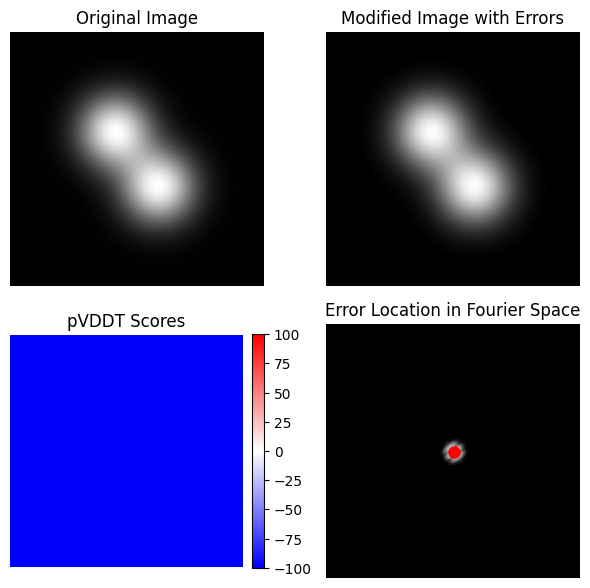

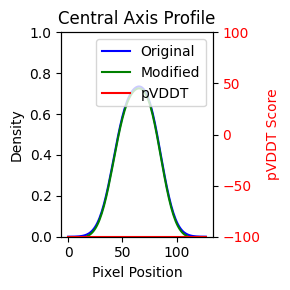

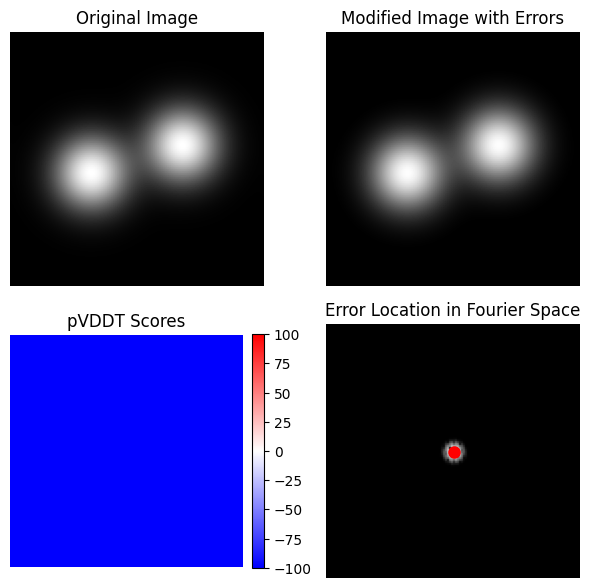

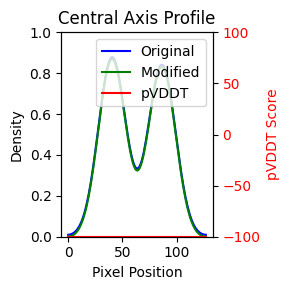

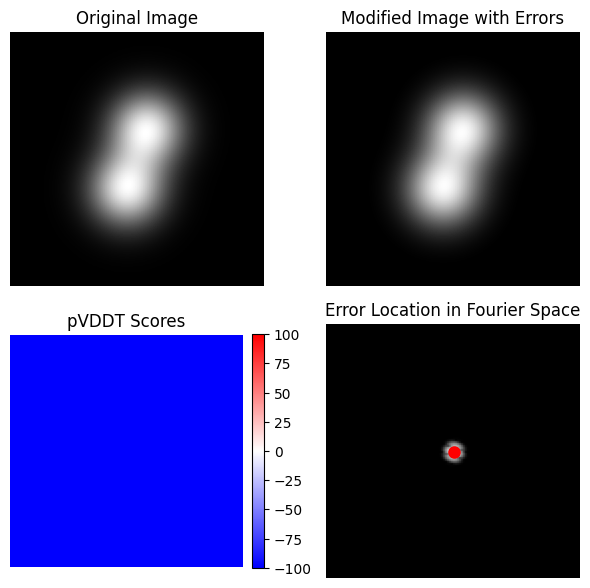

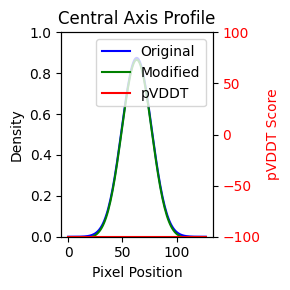

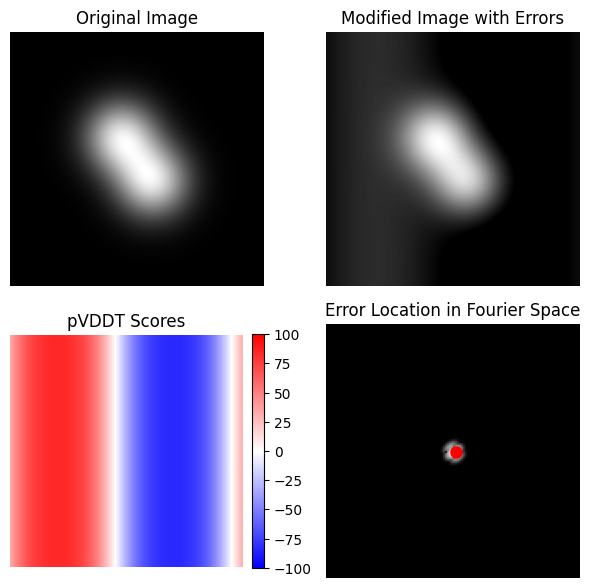

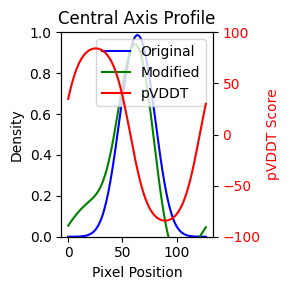

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.stats import norm
import ipywidgets as widgets
from IPython.display import display

# Function to generate a synthetic 2D image (e.g., sum of two Gaussians)
def generate_synthetic_image(N):
    x = np.linspace(-1, 1, N)
    y = np.linspace(-1, 1, N)
    X, Y = np.meshgrid(x, y)
    sigma = 0.2

    # First Gaussian blob
    rho1 = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    x_roll = np.random.randint(-N//4, N//4)
    y_roll = np.random.randint(-N//4, N//4)
    rho1 = np.roll(rho1, x_roll, axis=0)
    rho1 = np.roll(rho1, y_roll, axis=1)

    # Second Gaussian blob
    rho2 = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    rho2 = np.roll(rho2, -x_roll, axis=0)
    rho2 = np.roll(rho2, -y_roll, axis=1)

    # Sum and normalize
    rho_sum = rho1 + rho2
    rho_sum /= np.max(rho_sum)
    return rho_sum

# Compute the Fourier transform of the image
def compute_structure_factor(rho):
    F = fft2(rho)
    F_shifted = fftshift(F)
    return F_shifted

# Introduce different types of errors (both phase and amplitude)
def introduce_errors(F, max_phase_error, error_type, amplitude_error, point_location=None, radius=None):
    amplitudes = np.abs(F)
    phases = np.angle(F)
    N = F.shape[0]
    phase_errors = np.zeros_like(phases)
    amplitude_errors = np.zeros_like(amplitudes)

    if error_type == 'single_point':
        # Apply errors to a specified point in Fourier space
        if point_location is None:
            # Default to center
            i, j = N // 2, N // 2
        else:
            i, j = point_location
        phase_error = np.random.choice([-max_phase_error, max_phase_error])
        phase_errors[i % N, j % N] = phase_error

        amplitude_errors[i % N, j % N] = amplitude_error * amplitudes[i % N, j % N]

    elif error_type == 'radial_frequency':
        # Apply errors to a ring (annulus) in Fourier space
        if radius is None:
            radius = N // 10  # Default radius
        center = N // 2
        Y, X = np.ogrid[:N, :N]
        distance = np.sqrt((X - center)**2 + (Y - center)**2)
        mask = (distance >= radius - 1) & (distance <= radius)
        phase_error = np.random.choice([-max_phase_error, max_phase_error])
        phase_errors[mask] = phase_error

        amplitude_errors[mask] = amplitude_error * amplitudes[mask]

    elif error_type == 'uniform':
        # Apply uniform errors to all Fourier components
        phase_error = np.random.choice([-max_phase_error, max_phase_error])
        phase_errors = np.full_like(phases, phase_error)

        amplitude_errors = amplitude_error * amplitudes

    elif error_type == 'random':
        # Apply random errors to all Fourier components
        phase_errors = np.random.uniform(-max_phase_error, max_phase_error, phases.shape)

        amplitude_errors = amplitude_error * amplitudes * np.random.uniform(-1, 1, amplitudes.shape)

    else:
        raise ValueError("Invalid error_type. Choose from 'single_point', 'radial_frequency', 'uniform', or 'random'.")

    new_amplitudes = amplitudes + amplitude_errors
    new_phases = phases + phase_errors

    F_new = new_amplitudes * np.exp(1j * new_phases)
    return F_new, phase_errors, amplitude_errors

# Compute the inverse Fourier transform to get the modified image
def compute_modified_image(F_modified):
    F_ishifted = ifftshift(F_modified)
    rho_modified = ifft2(F_ishifted)
    rho_modified = np.real(rho_modified)
    return rho_modified

# Main simulation function with interactive widgets
def simulation_phase_error_interactive():
    # Parameters
    N = 128  # Image size

    # Initialize variables
    rho = generate_synthetic_image(N)
    F = compute_structure_factor(rho)

    # Interactive widgets
    error_type_widget = widgets.Dropdown(
        options=['single_point', 'radial_frequency', 'uniform', 'random'],
        value='single_point',
        description='Error Type:',
    )

    max_phase_error_widget = widgets.FloatSlider(
        value=np.pi/8,
        min=0,
        max=np.pi,
        step=np.pi/32,
        description='Max Phase Error:',
        readout_format='.2f',
    )

    amplitude_error_widget = widgets.FloatSlider(
        value=0.0,
        min=0.0,
        max=1.0,
        step=0.05,
        description='Amplitude Error:',
        readout_format='.2f',
    )

    # Widgets for 'single_point' error
    point_x_widget = widgets.IntSlider(
        value=N//2,
        min=0,
        max=N-1,
        description='Point X:',
    )

    point_y_widget = widgets.IntSlider(
        value=N//2,
        min=0,
        max=N-1,
        description='Point Y:',
    )

    # Widget for 'radial_frequency' error
    radius_widget = widgets.IntSlider(
        value=N//10,
        min=1,
        max=N//2,
        description='Radius:',
    )

    # Button to generate a new image
    new_image_button = widgets.Button(
        description='Generate New Image',
        button_style='primary',
        tooltip='Click to generate a new random synthetic image.',
    )

    # Function to update the image when button is clicked
    def on_new_image_button_clicked(b):
        nonlocal rho, F
        rho = generate_synthetic_image(N)
        F = compute_structure_factor(rho)
        # Update the plot
        update_plot(
            error_type=error_type_widget.value,
            max_phase_error=max_phase_error_widget.value,
            amplitude_error=amplitude_error_widget.value,
            point_x=point_x_widget.value,
            point_y=point_y_widget.value,
            radius=radius_widget.value,
        )

    new_image_button.on_click(on_new_image_button_clicked)

    # Function to update the plot
    def update_plot(error_type, max_phase_error, amplitude_error, point_x=N//2, point_y=N//2, radius=N//10):
        # Introduce errors
        if error_type == 'single_point':
            F_modified, phase_errors, amplitude_errors = introduce_errors(
                F, max_phase_error, error_type, amplitude_error, point_location=(point_y, point_x)
            )
        elif error_type == 'radial_frequency':
            F_modified, phase_errors, amplitude_errors = introduce_errors(
                F, max_phase_error, error_type, amplitude_error, radius=radius
            )
        else:
            F_modified, phase_errors, amplitude_errors = introduce_errors(
                F, max_phase_error, error_type, amplitude_error
            )

        rho_modified = compute_modified_image(F_modified)

        # Compute pVDDT scores (simplified)
        sigma = np.std(rho_modified - rho) * np.ones_like(rho)
        z_scores = (rho_modified - rho) / sigma
        p_values = norm.cdf(z_scores)
        pVDDT_scores = 200 * p_values - 100  # Rescale to [-100, 100]

        # Plotting

        # Create two figure panels side by side
        fig_left, axes_left = plt.subplots(2, 2, figsize=(6, 6))
        fig_right, ax_right = plt.subplots(figsize=(3, 3))

        # Adjust space between subplots
        plt.subplots_adjust(wspace=0.3)

        # First Figure (Left Panel)
        # Top Left: Original Image
        axes_left[0, 0].imshow(rho, cmap='gray', vmin=0, vmax=1)
        axes_left[0, 0].set_title('Original Image')
        axes_left[0, 0].axis('off')

        # Top Right: Modified Image
        axes_left[0, 1].imshow(rho_modified, cmap='gray', vmin=0, vmax=1)
        axes_left[0, 1].set_title('Modified Image with Errors')
        axes_left[0, 1].axis('off')

        # Bottom Left: pVDDT Scores
        im = axes_left[1, 0].imshow(pVDDT_scores, cmap='bwr', vmin=-100, vmax=100)
        axes_left[1, 0].set_title('pVDDT Scores')
        axes_left[1, 0].axis('off')
        fig_left.colorbar(im, ax=axes_left[1, 0], fraction=0.046, pad=0.04)

        # Bottom Right: Error Location in Fourier Space
        magnitude_spectrum = np.log1p(np.abs(F))
        axes_left[1, 1].imshow(magnitude_spectrum, cmap='gray')
        axes_left[1, 1].set_title('Error Location in Fourier Space')
        axes_left[1, 1].axis('off')

        if error_type == 'single_point':
            # Highlight the point where the errors are applied
            axes_left[1, 1].plot(point_x, point_y, 'ro', markersize=8)
        elif error_type == 'radial_frequency':
            # Draw a circle where the errors are applied
            circle = plt.Circle((N//2, N//2), radius, color='red', fill=False, linewidth=2)
            axes_left[1, 1].add_artist(circle)

        fig_left.tight_layout()

        # Second Figure (Right Panel): 1D profiles
        center_line = N // 2
        ax_density = ax_right
        ax_pvddt = ax_density.twinx()

        x = np.arange(N)
        # Plot density profiles
        ax_density.plot(x, rho[center_line, :], color='blue', label='Original')
        ax_density.plot(x, rho_modified[center_line, :], color='green', label='Modified')
        ax_density.set_ylim(0, 1)
        ax_density.set_ylabel('Density', color='black')
        ax_density.tick_params(axis='y', labelcolor='black')

        # Plot pVDDT profile
        ax_pvddt.plot(x, pVDDT_scores[center_line, :], color='red', label='pVDDT')
        ax_pvddt.set_ylim(-100, 100)
        ax_pvddt.set_ylabel('pVDDT Score', color='red')
        ax_pvddt.tick_params(axis='y', labelcolor='red')

        # Combine legends
        lines_density, labels_density = ax_density.get_legend_handles_labels()
        lines_pvddt, labels_pvddt = ax_pvddt.get_legend_handles_labels()
        ax_density.legend(lines_density + lines_pvddt, labels_density + labels_pvddt, loc='upper right')

        ax_density.set_title('Central Axis Profile')
        ax_density.set_xlabel('Pixel Position')

        fig_right.tight_layout()

        # Display the figures side by side
        from IPython.display import display as ipy_display
        ipy_display(fig_left)
        ipy_display(fig_right)
        plt.close(fig_left)
        plt.close(fig_right)

    # Function to update available widgets based on error_type
    def update_widgets(*args):
        if error_type_widget.value == 'single_point':
            point_x_widget.layout.display = ''
            point_y_widget.layout.display = ''
            radius_widget.layout.display = 'none'
        elif error_type_widget.value == 'radial_frequency':
            point_x_widget.layout.display = 'none'
            point_y_widget.layout.display = 'none'
            radius_widget.layout.display = ''
        else:
            point_x_widget.layout.display = 'none'
            point_y_widget.layout.display = 'none'
            radius_widget.layout.display = 'none'

    # Observe changes in error_type_widget to update widgets
    error_type_widget.observe(update_widgets, 'value')
    update_widgets()

    # Use interactive output
    out = widgets.interactive_output(
        update_plot,
        {
            'error_type': error_type_widget,
            'max_phase_error': max_phase_error_widget,
            'amplitude_error': amplitude_error_widget,
            'point_x': point_x_widget,
            'point_y': point_y_widget,
            'radius': radius_widget,
        }
    )

    # Display controls and output
    control_widgets = widgets.HBox([
        error_type_widget,
        max_phase_error_widget,
        amplitude_error_widget,
        point_x_widget,
        point_y_widget,
        radius_widget,
        new_image_button,
    ])
    display(control_widgets, out)

# Run the interactive simulation
simulation_phase_error_interactive()
